# Notebook to train the Hybrid ResNet-ViT & ViT

In [1]:
import torch
import torch.nn as nn
from torch.amp import GradScaler
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, accuracy_score, recall_score
from data_utils_torch import get_paths_and_labels, calculate_min_max, create_dataloader, extract_subject_id, clean_zone_identifier_files
from plotting_utils_torch import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.model_selection import StratifiedGroupKFold
import gc
from tqdm.auto import tqdm
from models3D import ResnetFeatureExtractor, ResNetViT, pureViT
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility    
seed = 10
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Set mixed precision     
USE_AMP = True if device.type == 'cuda' else False
scaler = GradScaler(enabled=USE_AMP)
print(f"Automatic Mixed Precision (AMP) enabled: {USE_AMP}")

#clean_zone_identifier_files("/home/diogommiranda/tese/")

/home/diogommiranda/tese/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-02 15:47:33.724708: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-02 15:47:34.608082: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda
Automatic Mixed Precision (AMP) enabled: True


# Select which Model to use
Note:
- When using ResNet and Hybrid Models the input shape is (91, 109, 91)
- When using PureViT the input shape is padded to (96, 112, 96) to make it divisible by a patch size of (16,16,16)

In [2]:
USE_MODEL = "hybrid" # Choose model: "hybrid", "purevit"

if USE_MODEL == "hybrid":
    print("Using Hybrid model. \nExpected input shape is (91, 109, 91)")
    apply_padding = False
elif USE_MODEL == "purevit":
    print("Using pure ViT model. \nExpected input shape is (96, 112, 96)")
    apply_padding = True
else:
    raise ValueError("Invalid model choice. Use 'hybrid' or 'purevit'.")

Using Hybrid model. 
Expected input shape is (91, 109, 91)


In [3]:
NORMALIZATION = "mni_reg_CV" # Name of the directory with the datasets
DATASET = "smci_pmci_balanced" # Choose dataset: "smci_pmci_balanced", "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 4 # Set batch size

# Get train paths and labels to calculate minmax values
train_paths, train_labels, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataloader(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max,
    apply_padding=apply_padding
    )

# Create test set with the minmax values from train
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)
test_data = create_dataloader(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    apply_padding=apply_padding
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci_balanced/train...
    Found 349 files for class 'smci'
    Found 314 files for class 'pmci'
Calculated Min: -0.3496308922767639, Max: 2.7912356853485107
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci_balanced/test...
    Found 87 files for class 'smci'
    Found 78 files for class 'pmci'


torch.Size([1, 91, 109, 91])
Min: 0.11078770458698273, Max: 0.8640980124473572


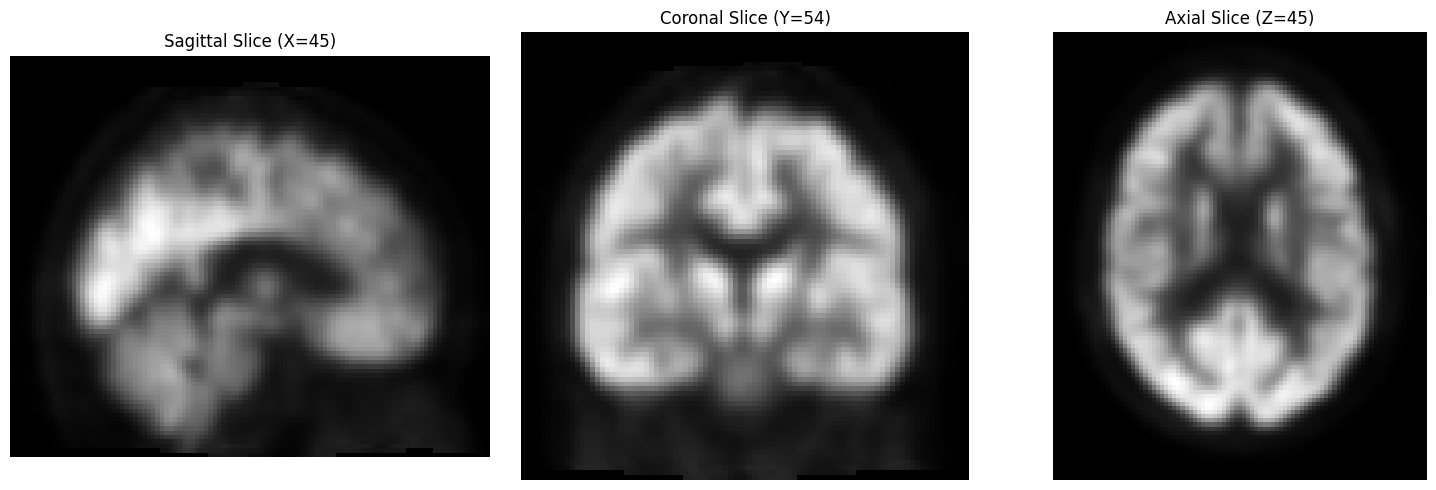

In [4]:
# Verify data with a test sample
i = 0
for data, label in test_data:
    view_image_data(data[i])
    #data[i] = torch.flip(data[i], dims=[3])
    #view_image_data(data[i])
    print(data[i].shape)
    min_val = data[i].min().item()
    max_val = data[i].max().item()
    print(f"Min: {min_val}, Max: {max_val}")
    break

In [5]:
# Setting configurations

resnet_config = {
    'block': 'basic',
    'layers': [2, 2, 2, 2], # [2, 2, 2, 2] for ResNet18, [3, 4, 6, 3] for ResNet34
    'block_inplanes': [64, 128, 256, 512],
    'spatial_dims': 3,
    'n_input_channels': 1,
    'conv1_t_stride': 2,
    'num_classes': 1, 
    'shortcut_type': 'B',
    'bias_downsample': True
}

if USE_MODEL == "hybrid":
    if resnet_config['layers'] == [2, 2, 2, 2]:
        print("Using ResNet18 configuration")
        dir1 = "/resnet18/"
    elif resnet_config['layers'] == [3, 4, 6, 3]:
        print("Using ResNet34 configuration")
        dir1 = "/resnet34/"

vit_config = {
    'in_channels': 256,
    'img_size': (6,7,6),
    'patch_size': (1,1,1),  
    'num_heads': 3,
    'hidden_size': 192,
    'mlp_dim': 768,
    'num_layers': 2,
    'proj_type': 'perceptron',
    'pos_embed_type': 'sincos',
    'classification': True,
    'num_classes': 1,
    'dropout_rate': 0.1,
    'spatial_dims': 3,
    'post_activation': 'none',
    'qkv_bias': False,
    'save_attn': False
}

purevit_config = {
    'in_channels': 1,
    'img_size': (96,112,96),
    'patch_size': (16,16,16),
    'num_heads': 12,
    'hidden_size': 768,
    'mlp_dim': 3072,
    'num_layers': 12,
    'proj_type': 'perceptron',
    'pos_embed_type': 'sincos',
    'classification': True,
    'num_classes': 1,
    'dropout_rate': 0.0,
    'spatial_dims': 3,
    'post_activation': 'none',
    'qkv_bias': False,
    'save_attn': False
    }

Using ResNet18 configuration


# Select whether to save the attention maps

In [6]:
SAVE_ATTENTION = True

if SAVE_ATTENTION:
    print("Saving attention maps")
    vit_config['save_attn'] = True
    purevit_config['save_attn'] = True
else:
    print("Not saving attention maps")
    vit_config['save_attn'] = False
    purevit_config['save_attn'] = False

Saving attention maps


# Select whether to use ROI loss

In [7]:
USE_ROI_LOSS = False

if USE_ROI_LOSS:
    print("Using ROI loss")
    vit_config['save_attn'] = True
    purevit_config['save_attn'] = True
    dir0 = "roi_loss/"
else:
    print("Not using ROI loss")
    #vit_config['save_attn'] = False
    #purevit_config['save_attn'] = False
    dir0 = "normal/"

Not using ROI loss


# Nested Cross-Validation

In [8]:
# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----

N_SPLITS = 5 # Number of splits for cross-validation
NUM_EPOCHS = 300
EARLY_STOP_PATIENCE = 20

#learning_rates = [2e-7, 4e-7]
learning_rates = [2e-7] # CASO DECIDA USAR LR EM FUNCAO DE HEADS, DESCOMENTAR E EDITAR EM BAIXO
weight_decays = [4e-3]

layers_list = [7]
heads_list = [8]

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

overall_start_time = time.time()

print(f"\nArquitectures to be tested:\nlayers_list={layers_list}\n\t heads_list={heads_list}\n")
# For-loop over determined number of vit layers and heads
for dropout in [0.0]:
    vit_config['dropout_rate'] = dropout
    print(f"Testing dropout rate: {dropout}")
    for layers in layers_list:
        vit_config['num_layers'] = layers
        for heads in heads_list:
            vit_config['num_heads'] = heads
            if heads == 1:
                vit_config['hidden_size'] = 66
                vit_config['mlp_dim'] = 264
            elif heads == 2:
                vit_config['hidden_size'] = 126
                vit_config['mlp_dim'] = 504
            elif heads == 3:
                vit_config['hidden_size'] = 192
                vit_config['mlp_dim'] = 768
            elif heads == 4:
                vit_config['hidden_size'] = 252
                vit_config['mlp_dim'] = 1008
            elif heads == 5:
                vit_config['hidden_size'] = 330
                vit_config['mlp_dim'] = 1320
            elif heads == 6:
                vit_config['hidden_size'] = 384
                vit_config['mlp_dim'] = 1536
            elif heads == 7:
                vit_config['hidden_size'] = 462
                vit_config['mlp_dim'] = 1848
            elif heads == 8:
                vit_config['hidden_size'] = 504
                vit_config['mlp_dim'] = 2016
            elif heads == 9:
                vit_config['hidden_size'] = 576
                vit_config['mlp_dim'] = 2304
            elif heads == 12:
                vit_config['hidden_size'] = 768
                vit_config['mlp_dim'] = 3072
            else:
                raise ValueError(f"Unsupported number of heads: {heads}. Supported values are 1 to 9.")
                
            dir3 = f"num_layers_{vit_config['num_layers']}/" 
            dir4 = f"num_heads_{vit_config['num_heads']}/"
            
            # Base directory for layers and heads
            if USE_MODEL == "hybrid":
                print(f"\nUsing Hybrid Model.\n")
                RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/" + dir0 + "resnetvit/" + DATASET + dir1 + str(BATCH_SIZE) + "B/" + dir3 + dir4
                if SAVE_ATTENTION:
                    RESULTS_BASE_DIR += "save_attn/"
            elif USE_MODEL == "purevit":
                print("\nUsing pureViT model.\n")
                RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/" + dir0 + "purevit/" + DATASET + "/" + str(BATCH_SIZE) + "B/" + dir3 + dir4
                if SAVE_ATTENTION:
                    RESULTS_BASE_DIR += "save_attn/"
            else:
                raise ValueError("Invalid model type. Choose 'hybrid' or 'purevit'.")
            os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
            
            # For-loop over determined learning rates and weight decays
            for current_lr in learning_rates:
                for current_wd in weight_decays:
                    print("=" * 60)
                    print(f"Testing Combination: ViT Layers={layers}, ViT Heads={heads}, LR={current_lr:.1e}, WeightDecay={current_wd:.0e}")
                    print(f"Hidden Size: {vit_config['hidden_size']}, MLP Dim: {vit_config['mlp_dim']}, Dropout: {dropout}")

                    combo_dir_name = f"LR_{current_lr:.1e}_WD_{current_wd:.0e} (dropout={dropout})"
                        
                    combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
                    if os.path.exists(combo_results_dir):
                        print(f"\nDirectory {combo_results_dir} already exists. Skipping...\n")
                        continue
                    
                    os.makedirs(combo_results_dir, exist_ok=True)
                    print(f"    Saving results for this combo to: {combo_results_dir}")
                    print("=" * 60)

                    start_time_combination = time.time()
                    
                    current_combo_val_losses = []
                    current_combo_val_accuracies = []
                    current_combo_val_aucs = []
                    current_combo_best_epoch = []
                    
                    current_combo_val_sensitivities = []
                    current_combo_val_specificities = []
                    current_combo_val_baccs = []
                    current_combo_val_f1s = []
                    current_combo_val_mccs = []

                    current_combo_test_losses = []
                    current_combo_test_accuracies = []
                    current_combo_test_aucs = []
                    
                    current_combo_test_sensitivities = []
                    current_combo_test_specificities = []
                    current_combo_test_baccs = []
                    current_combo_test_f1s = []
                    current_combo_test_mccs = []

                    fold_no = 1

                    # K-Fold Cross-Validation
                    for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
                        
                        
                        if fold_no > 1:
                            continue # Skip folds after the first one for testing purposes
                        
                        
                        print("-" * 60)
                        print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr:.1e} and WD={current_wd:.0e}...")
                        start_time_fold = time.time()

                        # Get paths and labels for the current fold
                        fold_train_paths = train_paths[train_indices]
                        fold_train_labels = train_labels[train_indices]
                        fold_val_paths = train_paths[val_indices]
                        fold_val_labels = train_labels[val_indices]

                        # Verify subject separation
                        train_subjects = set(subject_ids[train_indices])
                        val_subjects = set(subject_ids[val_indices])
                        if not train_subjects.isdisjoint(val_subjects):
                                raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")

                        print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

                        # Calculate minmax parameters for the current training fold
                        fold_min, fold_max = calculate_min_max(fold_train_paths)

                        # Create fold train dataset
                        fold_train_data = create_dataloader(
                            paths=fold_train_paths,
                            labels=fold_train_labels,
                            batch_size=BATCH_SIZE,
                            volume_shape=VOLUME_SHAPE,
                            is_training=True, 
                            seed=seed,
                            min_val=fold_min, 
                            max_val=fold_max,
                            apply_padding=apply_padding
                        ) 
                        
                        # Create fold validation dataset
                        fold_val_data = create_dataloader(
                            paths=fold_val_paths,
                            labels=fold_val_labels,
                            batch_size=BATCH_SIZE,
                            volume_shape=VOLUME_SHAPE,
                            is_training=False, 
                            seed=None,
                            min_val=fold_min, 
                            max_val=fold_max,
                            apply_padding=apply_padding
                        )
                        
                        test_data = create_dataloader(
                            paths=test_paths,
                            labels=test_labels,
                            batch_size=BATCH_SIZE,
                            volume_shape=VOLUME_SHAPE,
                            is_training=False,
                            seed=None,
                            min_val=fold_min, 
                            max_val=fold_max,
                            apply_padding=apply_padding
                            )

                        if fold_train_data is None or fold_val_data is None or test_data is None:
                                raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")
                            
                        # Compute class weights for the current fold
                        unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
                        print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
                        pos_weight_val = class_counts[0] / class_counts[1]
                        pos_weight_val = torch.tensor([pos_weight_val], device=device)
                        print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

                        # Create the model
                        if USE_MODEL == "hybrid":
                            resnet_feature_extractor = ResnetFeatureExtractor(resnet_config=resnet_config)
                            model = ResNetViT(resnet_feature_extractor, vit_config).to(device)
                        elif USE_MODEL == "purevit":
                            model = pureViT(purevit_config).to(device)
                        else:
                            raise ValueError("Invalid model type. Choose 'hybrid' or 'purevit'.")

                        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)
                        
                        optimizer = torch.optim.Adam(model.parameters(), lr=current_lr, weight_decay=current_wd)
                    
                        best_val_loss = float('inf')
                        best_val_bacc = -float('inf')
                        epochs_no_improve = 0
                        best_epoch = 0
                        best_model_state = None
                        stopped_epoch = NUM_EPOCHS 

                        # Initialize history for this fold
                        history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': [],
                                'val_sensitivity': [], 'val_specificity': [], 'val_bacc': [], 'val_f1': [], 'val_mcc': []}

                        for epoch in tqdm(range(NUM_EPOCHS)):
                            epoch_start_time = time.time()
                            history['epoch'].append(epoch + 1)

                            # ---------------- Train phase ----------------
                            model.train()
                            
                            running_loss = 0.0
                            train_pred_probs = []
                            train_targets = []
                            
                            for i, (inputs, labels) in enumerate(fold_train_data):
                                inputs = inputs.to(device)
                                labels = labels.float().unsqueeze(1).to(device)
                                
                                optimizer.zero_grad()
                                
                                # Mixed precision
                                with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                                    outputs, attention_maps = model(inputs, return_attention=SAVE_ATTENTION)
                                    loss = criterion(outputs, labels)

                                scaler.scale(loss).backward()
                                scaler.step(optimizer)
                                scaler.update()

                                running_loss += loss.item() * inputs.size(0)
                                
                                prob_outputs = torch.sigmoid(outputs)
                                train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
                                train_targets.extend(labels.detach().cpu().numpy())

                            train_targets = np.array(train_targets).flatten()
                            train_pred_probs = np.array(train_pred_probs).flatten()
                            
                            # Calculate training metrics for the epoch
                            train_loss = running_loss / len(fold_train_data.dataset)
                            train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
                            train_auc = roc_auc_score(train_targets, train_pred_probs)
                            history['train_loss'].append(train_loss)
                            history['train_accuracy'].append(train_acc)
                            history['train_auc'].append(train_auc)

                            # ---------------- Validation phase ----------------
                            model.eval()
                            val_running_loss = 0.0
                            val_pred_probs = []
                            val_targets = []

                            with torch.inference_mode():
                                for inputs, labels in fold_val_data:
                                    inputs = inputs.to(device)
                                    labels = labels.float().unsqueeze(1).to(device)

                                    # Mixed precision
                                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                                        outputs, attention_maps = model(inputs, return_attention=SAVE_ATTENTION)
                                        loss = criterion(outputs, labels)

                                    val_running_loss += loss.item() * inputs.size(0)

                                    prob_outputs = torch.sigmoid(outputs)
                                    val_pred_probs.extend(prob_outputs.cpu().numpy())
                                    val_targets.extend(labels.cpu().numpy())
                                    
                            val_targets = np.array(val_targets).flatten()
                            val_pred_probs = np.array(val_pred_probs).flatten()

                            # Calculate validation metrics for the epoch
                            val_loss = val_running_loss / len(fold_val_data.dataset)
                            val_acc = accuracy_score(val_targets, val_pred_probs >= 0.5)
                            val_auc = roc_auc_score(val_targets, val_pred_probs)
                            
                            val_true = val_targets.astype(int)
                            val_pred = (val_pred_probs >= 0.5).astype(int)
                            
                            val_sensitivity = recall_score(val_true, val_pred, pos_label=1)
                            val_specificity = recall_score(val_true, val_pred, pos_label=0)
                            val_bacc = balanced_accuracy_score(val_true, val_pred)
                            val_f1 = f1_score(val_true, val_pred, average='weighted')
                            val_mcc = matthews_corrcoef(val_true, val_pred)
                            
                            
                            history['val_loss'].append(val_loss)
                            history['val_accuracy'].append(val_acc)
                            history['val_auc'].append(val_auc)
                            
                            history['val_sensitivity'].append(val_sensitivity)
                            history['val_specificity'].append(val_specificity)
                            history['val_bacc'].append(val_bacc)
                            history['val_f1'].append(val_f1)
                            history['val_mcc'].append(val_mcc)

                            # Print Epoch Summary
                            epoch_duration = time.time() - epoch_start_time
                            #print(f"    Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.2f}s] - "
                            #        f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f} | "
                            #        f"Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")
                            

                            # Early stopping check
                            if DATASET == "smci_pmci_balanced":
                                # For smci_pmci_balanced, we monitor validation loss for early stopping (balanced dataset)
                                if val_loss < best_val_loss:
                                    best_val_loss = val_loss
                                    epochs_no_improve = 0
                                    # Save the model state with the lowest validation loss
                                    best_model_state = model.state_dict()
                                    best_epoch = epoch + 1
                                else:
                                    epochs_no_improve += 1
                            elif DATASET == "smci_pmci":
                                # For smci_pmci, we save the best balanced accuracy to deal with class imbalance and monitor the val loss for early stopping to avoid overfitting                  
                                if val_loss < best_val_loss:
                                    best_val_loss = val_loss
                                    epochs_no_improve = 0    
                                else:
                                    epochs_no_improve += 1
                                    
                                if val_bacc > best_val_bacc:
                                    best_val_bacc = val_bacc
                                    # Save the best model state
                                    best_model_state = model.state_dict()
                                    best_epoch = epoch + 1
                            else:
                                raise ValueError("Invalid dataset. Add option to the if statement.")
                            
                            if epochs_no_improve >= EARLY_STOP_PATIENCE and epoch > 40:
                                model.load_state_dict(best_model_state)
                                print(f"\nEarly stopping triggered. Restoring best model weights from epoch {best_epoch}.\n")
                                break
                            
                            
                            #if train_loss < 0.15:
                                #print(f" We stop training here because overfitting is already happening.")
                                #break
                        
                        
                        # Restore the best model state if early stopping was not triggered
                        if epochs_no_improve < EARLY_STOP_PATIENCE:
                            print(f"Training completed for {NUM_EPOCHS} epochs. Restoring best model weights from epoch {best_epoch}.")
                            model.load_state_dict(best_model_state)
                        
                        # Save fold history and plots
                        fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
                        os.makedirs(fold_dir, exist_ok=True)
                        history_df = pd.DataFrame(history)
                        history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
                        history_df.to_csv(history_csv_path, index=False)
                        plot_loss_curves(history, fold_dir)

                        # Evaluate the fold
                        best_epoch_index = best_epoch - 1
                        
                        val_loss_best = history['val_loss'][best_epoch_index]
                        val_accuracy_best = history['val_accuracy'][best_epoch_index]
                        val_auc_best = history['val_auc'][best_epoch_index]
                        
                        val_sensitivity_best = history['val_sensitivity'][best_epoch_index]
                        val_specificity_best = history['val_specificity'][best_epoch_index]
                        val_bacc_best = history['val_bacc'][best_epoch_index]
                        val_f1_best = history['val_f1'][best_epoch_index]
                        val_mcc_best = history['val_mcc'][best_epoch_index]
                        
                        print(f"    Fold {fold_no} - Best Epoch {best_epoch}, Val Loss: {val_loss_best:.4f}, Acc: {val_accuracy_best:.4f}, AUC: {val_auc_best:.4f}, \n"
                            f"    Sensitivity: {val_sensitivity_best:.4f}, Specificity: {val_specificity_best:.4f}, BACC: {val_bacc_best:.4f}, F1: {val_f1_best:.4f}, MCC: {val_mcc_best:.4f}")

                        # Append results for this fold
                        current_combo_val_losses.append(val_loss_best)
                        current_combo_val_accuracies.append(val_accuracy_best)
                        current_combo_val_aucs.append(val_auc_best)
                        current_combo_best_epoch.append(best_epoch)
                        
                        current_combo_val_sensitivities.append(val_sensitivity_best)
                        current_combo_val_specificities.append(val_specificity_best)
                        current_combo_val_baccs.append(val_bacc_best)
                        current_combo_val_f1s.append(val_f1_best)
                        current_combo_val_mccs.append(val_mcc_best)
                        
                        optimizer_name = optimizer.__class__.__name__
                        
                        end_time_fold = time.time()
                        print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
                        fold_no += 1
                        
                        # Save the validation metrics for current fold
                        val_metrics_file_path = os.path.join(fold_dir, "val_results.txt")
                        with open(val_metrics_file_path, "w") as f:
                            f.write("--- Validation Metrics ---\n")
                            f.write(f"Loss:        {val_loss_best:.4f}\n")
                            f.write(f"Accuracy:    {val_accuracy_best:.4f}\n")
                            f.write(f"Sensitivity: {val_sensitivity_best:.4f}\n")
                            f.write(f"Specificity: {val_specificity_best:.4f}\n")
                            f.write(f"Balanced Accuracy (BACC): {val_bacc_best:.4f}\n")
                            f.write(f"F1 Score (Weighted):      {val_f1_best:.4f}\n")
                            f.write(f"Matthews Corr Coef (MCC): {val_mcc_best:.4f}\n")
                            f.write(f"Area Under the Curve (AUC): {val_auc_best:.4f}\n")
                        
                        # ---------------- Evaluate the model on the test data ---------------- 
                        model.eval()
                        test_running_loss = 0.0
                        test_pred_probs = []
                        test_targets = []

                        with torch.inference_mode():
                            for inputs, labels in test_data:
                                inputs = inputs.to(device)
                                labels = labels.float().unsqueeze(1).to(device)

                                # Mixed precision
                                with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                                    outputs, attention_maps = model(inputs, return_attention=SAVE_ATTENTION)
                                    loss = criterion(outputs, labels)

                                test_running_loss += loss.item() * inputs.size(0)
                            
                                prob_outputs = torch.sigmoid(outputs)
                                
                                test_pred_probs.extend(prob_outputs.cpu().numpy())
                                test_targets.extend(labels.cpu().numpy())

                        test_targets = np.array(test_targets).flatten()
                        test_pred_probs = np.array(test_pred_probs).flatten()

                        # Calculate test loss and accuracy
                        test_loss = test_running_loss / len(test_data.dataset)
                        test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)

                        y_true = test_targets.astype(int)
                        y_pred = (test_pred_probs >= 0.5).astype(int)

                        # Calculate metrics
                        test_sensitivity = recall_score(y_true, y_pred, pos_label=1)
                        test_specificity = recall_score(y_true, y_pred, pos_label=0)
                        test_bacc = balanced_accuracy_score(y_true, y_pred)
                        test_f1 = f1_score(y_true, y_pred, average='weighted')
                        test_mcc = matthews_corrcoef(y_true, y_pred)
                        test_auc_score = roc_auc_score(y_true, y_pred)
                        
                        print(f"    Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, AUC: {test_auc_score:.4f}, \n"
                            f"    Sensitivity: {test_sensitivity:.4f}, Specificity: {test_specificity:.4f}, BACC: {test_bacc:.4f}, F1: {test_f1:.4f}, MCC: {test_mcc:.4f}")
                        
                        classes = DATASET.split("_")
                        class0, class1 = classes[0], classes[1]
                        target_names = [class0, class1]

                        # Save the confusion matrix plot
                        make_confusion_matrix(y_true=y_true,
                                            y_pred=y_pred,
                                            classes=target_names,
                                            figsize=(8, 8),
                                            text_size=15,
                                            save_dir=fold_dir)

                        # Save the test loss and accuracy and the evaluation metrics
                        result_file_path = os.path.join(fold_dir, "test_results.txt")
                        with open(result_file_path, "w") as f:
                            f.write(f"[{test_loss}, {test_acc}]\n\n")
                            f.write("--- Evaluation Metrics on Test Set ---\n")
                            f.write(f"Accuracy:    {test_acc:.4f}\n")
                            f.write(f"Sensitivity: {test_sensitivity:.4f}\n")
                            f.write(f"Specificity: {test_specificity:.4f}\n")
                            f.write(f"Balanced Accuracy (BACC): {test_bacc:.4f}\n")
                            f.write(f"F1 Score (Weighted):      {test_f1:.4f}\n")
                            f.write(f"Matthews Corr Coef (MCC): {test_mcc:.4f}\n")
                            f.write(f"Area Under the Curve (AUC): {test_auc_score:.4f}\n")
                            
                        test_config = {
                            "vit_config": vit_config,
                            "num_epochs": int(best_epoch),
                            "optimizer": optimizer_name,
                            "optimizer_params": {
                                "lr": float(current_lr),
                                "weight_decay": float(current_wd)
                            },
                            "batch_size": BATCH_SIZE,
                            "seed": seed,
                            "dataset": DATASET
                        }
                        params_file_path = os.path.join(fold_dir, "test_config.json")
                        with open(params_file_path, "w") as f:
                            json.dump(test_config, f, indent=4)
                                
                        # Append results for this fold
                        current_combo_test_losses.append(test_loss)
                        current_combo_test_accuracies.append(test_acc)
                        current_combo_test_aucs.append(test_auc_score)
                        
                        current_combo_test_sensitivities.append(test_sensitivity)
                        current_combo_test_specificities.append(test_specificity)
                        current_combo_test_baccs.append(test_bacc)
                        current_combo_test_f1s.append(test_f1)
                        current_combo_test_mccs.append(test_mcc)
                        
                        # Free resources
                        #del model, optimizer, criterion, fold_train_data, fold_val_data, history, history_df, best_model_state
                        #if device.type == 'cuda':
                            #torch.cuda.empty_cache() 
                        #gc.collect() 

                    end_time_combination = time.time()
                    print(f"Combination finished in {end_time_combination - start_time_combination:.2f} seconds.")

                    # Aggregate results across folds
                    avg_loss = np.mean(current_combo_val_losses)
                    std_loss = np.std(current_combo_val_losses)
                    avg_acc = np.mean(current_combo_val_accuracies)
                    std_acc = np.std(current_combo_val_accuracies)
                    avg_auc = np.mean(current_combo_val_aucs)
                    std_auc = np.std(current_combo_val_aucs)
                    
                    avg_sensitivity = np.mean(current_combo_val_sensitivities)
                    avg_specificity = np.mean(current_combo_val_specificities)
                    avg_bacc = np.mean(current_combo_val_baccs)
                    std_bacc = np.std(current_combo_val_baccs)
                    avg_f1 = np.mean(current_combo_val_f1s)
                    std_f1 = np.std(current_combo_val_f1s)
                    avg_mcc = np.mean(current_combo_val_mccs)

                    combo_average_results = {
                        'avg_val_loss': avg_loss,
                        'std_val_loss': std_loss,
                        'avg_val_accuracy': avg_acc,
                        'std_val_accuracy': std_acc,
                        'avg_val_auc': avg_auc,
                        'std_val_auc': std_auc,
                        'individual_losses': [round(loss, 4) for loss in current_combo_val_losses],
                        'individual_accuracies': [round(acc, 4) for acc in current_combo_val_accuracies],
                        'individual_aucs': [round(auc, 4) for auc in current_combo_val_aucs],
                        'best_epoch_per_fold': list(current_combo_best_epoch),
                        'avg_val_sensitivity': avg_sensitivity,
                        'avg_val_specificity': avg_specificity,
                        'avg_val_bacc': avg_bacc,
                        'std_val_bacc': std_bacc,
                        'avg_val_f1': avg_f1,
                        'std_val_f1': std_f1,
                        'avg_val_mcc': avg_mcc,
                        'individual_sensitivities': [round(sensitivity, 4) for sensitivity in current_combo_val_sensitivities],
                        'individual_specificities': [round(specificity, 4) for specificity in current_combo_val_specificities],
                        'individual_baccs': [round(bacc, 4) for bacc in current_combo_val_baccs],
                        'individual_f1s': [round(f1, 4) for f1 in current_combo_val_f1s],
                        'individual_mccs': [round(mcc, 4) for mcc in current_combo_val_mccs],
                    }

                    # Save results in a txt file and the parameters in a json file
                    val_results_df = pd.DataFrame(combo_average_results)
                    display_cols = list(combo_average_results.keys())

                    val_results_filepath = os.path.join(combo_results_dir, "validation_results.txt")
                    with open(val_results_filepath, "w") as f:
                        print("Validation Results Summary:", file=f)
                        print(val_results_df[display_cols].round(6).to_string(index=False, max_colwidth=None, line_width=250), file=f)

                        print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)

                    avg_test_loss = np.mean(current_combo_test_losses)
                    std_test_loss = np.std(current_combo_test_losses)
                    avg_test_acc = np.mean(current_combo_test_accuracies)
                    std_test_acc = np.std(current_combo_test_accuracies)
                    avg_test_auc = np.mean(current_combo_test_aucs)
                    std_test_auc = np.std(current_combo_test_aucs)
                    
                    avg_test_sensitivity = np.mean(current_combo_test_sensitivities)
                    std_test_sensitivity = np.std(current_combo_test_sensitivities)
                    avg_test_specificity = np.mean(current_combo_test_specificities)
                    std_test_specificity = np.std(current_combo_test_specificities)
                    avg_test_bacc = np.mean(current_combo_test_baccs)
                    std_test_bacc = np.std(current_combo_test_baccs)
                    avg_test_f1 = np.mean(current_combo_test_f1s)
                    std_test_f1 = np.std(current_combo_test_f1s)
                    avg_test_mcc = np.mean(current_combo_test_mccs)
                    std_test_mcc = np.std(current_combo_test_mccs)

                    combo_test_average_results = {
                        'avg_test_loss': avg_test_loss,	
                        'std_test_loss': std_test_loss,
                        'avg_test_accuracy': avg_test_acc,
                        'std_test_accuracy': std_test_acc,
                        'avg_test_auc': avg_test_auc,
                        'std_test_auc': std_test_auc,
                        'individual_test_losses': [round(loss, 4) for loss in current_combo_test_losses],
                        'individual_test_accuracies': [round(acc, 4) for acc in current_combo_test_accuracies],
                        'individual_test_aucs': [round(auc, 4) for auc in current_combo_test_aucs],
                        'avg_test_sensitivity': avg_test_sensitivity,
                        'std_test_sensitivity': std_test_sensitivity,
                        'avg_test_specificity': avg_test_specificity,
                        'std_test_specificity': std_test_specificity,
                        'avg_test_bacc': avg_test_bacc,
                        'std_test_bacc': std_test_bacc,
                        'avg_test_f1': avg_test_f1,
                        'std_test_f1': std_test_f1,
                        'avg_test_mcc': avg_test_mcc,
                        'std_test_mcc': std_test_mcc,
                        'individual_test_sensitivities': [round(sensitivity, 4) for sensitivity in current_combo_test_sensitivities],
                        'individual_test_specificities': [round(specificity, 4) for specificity in current_combo_test_specificities],
                        'individual_test_baccs': [round(bacc, 4) for bacc in current_combo_test_baccs],
                        'individual_test_f1s': [round(f1, 4) for f1 in current_combo_test_f1s],
                        'individual_test_mccs': [round(mcc, 4) for mcc in current_combo_test_mccs],
                    }
                        
                    test_results_df = pd.DataFrame(combo_test_average_results)
                    display_cols = list(combo_test_average_results.keys())
                    test_results_filepath = os.path.join(combo_results_dir, "average_test_results.txt")
                    with open(test_results_filepath, "w") as f:
                        print("Test Results Summary:", file=f)
                        print(test_results_df[display_cols].round(6).to_string(index=False, max_colwidth=None, line_width=250), file=f)

                        print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)

                    training_config = {
                        "vit_config": vit_config,
                        "num_folds": N_SPLITS,
                        "num_epochs": NUM_EPOCHS,
                        "early_stop_patience": EARLY_STOP_PATIENCE,
                        "optimizer": optimizer_name,
                        "optimizer_params": {
                            "lr": float(current_lr),
                            "weight_decay": float(current_wd)
                        },
                        "batch_size": BATCH_SIZE,
                        "seed": seed,
                        "dataset": DATASET
                    }
                    params_file_path = os.path.join(combo_results_dir, "training_config.json")
                    with open(params_file_path, "w") as f:
                        json.dump(training_config, f, indent=4)


Arquitectures to be tested:
layers_list=[7]
	 heads_list=[8]

Testing dropout rate: 0.0

Using Hybrid Model.

Testing Combination: ViT Layers=7, ViT Heads=8, LR=2.0e-07, WeightDecay=4e-03
Hidden Size: 504, MLP Dim: 2016, Dropout: 0.0
    Saving results for this combo to: /home/diogommiranda/tese/outputs/normal/resnetvit/smci_pmci_balanced/resnet18/4B/num_layers_7/num_heads_8/save_attn/LR_2.0e-07_WD_4e-03 (dropout=0.0)
------------------------------------------------------------
Training Fold 1/5 for LR=2.0e-07 and WD=4e-03...
  Train samples: 513, Validation samples: 150
Calculated Min: -0.2443523108959198, Max: 2.7912356853485107
  Fold train label counts: {0: 272, 1: 241}
  Calculated pos_weight for BCEWithLogitsLoss: 1.1286


 22%|██▏       | 65/300 [07:22<26:40,  6.81s/it]


Early stopping triggered. Restoring best model weights from epoch 46.

    Fold 1 - Best Epoch 46, Val Loss: 0.4161, Acc: 0.8200, AUC: 0.9019, 
    Sensitivity: 0.8493, Specificity: 0.7922, BACC: 0.8208, F1: 0.8200, MCC: 0.6418
    Fold 1 finished in 444.01 seconds.


    Test Loss: 0.7792, Test Accuracy: 0.7697, AUC: 0.7637, 
    Sensitivity: 0.6538, Specificity: 0.8736, BACC: 0.7637, F1: 0.7662, MCC: 0.5437
Combination finished in 444.99 seconds.


In [9]:
attn_map = model.get_attention_map(layer=7, head=1, average_heads=False)
print(f"Attention map shape: {attn_map.shape}")

Attention map shape: torch.Size([1, 253, 253])


In [10]:
global_min = float('inf')
global_max = float('-inf')
for i in range (1, 8):
    attn_map = model.get_attention_map(layer=7, head=i, average_heads=False)
    curr_min = np.min(attn_map[0, 0, 1:].detach().cpu().numpy())
    curr_max = np.max(attn_map[0, 0, 1:].detach().cpu().numpy())
    print(f"Head {i} - Min: {curr_min:.4f}, Max: {curr_max:.4f}")
    if curr_min < global_min:
        global_min = curr_min
    if curr_max > global_max:
        global_max = curr_max
print(f"Global Min: {global_min:.6f}, Global Max: {global_max:.6f}")

Head 1 - Min: 0.0023, Max: 0.0065
Head 2 - Min: 0.0024, Max: 0.0060
Head 3 - Min: 0.0026, Max: 0.0059
Head 4 - Min: 0.0027, Max: 0.0060
Head 5 - Min: 0.0024, Max: 0.0056
Head 6 - Min: 0.0025, Max: 0.0066
Head 7 - Min: 0.0026, Max: 0.0062
Global Min: 0.002282, Global Max: 0.006568


In [12]:
for i in range (1, 8):
    attn_map = model.get_attention_map(layer=2, head=i, average_heads=False)
    curr_min = np.min(attn_map[0, 0, 1:].detach().cpu().numpy())
    curr_max = np.max(attn_map[0, 0, 1:].detach().cpu().numpy())
    print(f"Head {i} - Min: {curr_min:.4f}, Max: {curr_max:.4f}")
    if curr_min < global_min:
        global_min = curr_min
    if curr_max > global_max:
        global_max = curr_max
print(f"Global Min: {global_min:.6f}, Global Max: {global_max:.6f}")

Head 1 - Min: 0.0024, Max: 0.0083
Head 2 - Min: 0.0021, Max: 0.0061
Head 3 - Min: 0.0027, Max: 0.0071
Head 4 - Min: 0.0024, Max: 0.0058
Head 5 - Min: 0.0026, Max: 0.0056
Head 6 - Min: 0.0022, Max: 0.0063
Head 7 - Min: 0.0027, Max: 0.0064
Global Min: 0.002118, Global Max: 0.008266


In [81]:
attn_map = model.get_attention_map(layer=7, head=None, average_heads=True)
print(f"Attention map shape: {attn_map.shape}")
cls_attn = attn_map[0, 0, 1:].detach().cpu()
print(f"CLS token attention vector shape (without self-attention value): {cls_attn.shape}")

cls_max = torch.max(cls_attn)
cls_min = torch.min(cls_attn)
print(f"CLS token attention values - Min: {cls_min:.4f}, Max: {cls_max:.4f}")

Attention map shape: torch.Size([1, 253, 253])
CLS token attention vector shape (without self-attention value): torch.Size([252])
CLS token attention values - Min: 0.0033, Max: 0.0046


In [82]:
cls_attn[97]

tensor(0.0033)

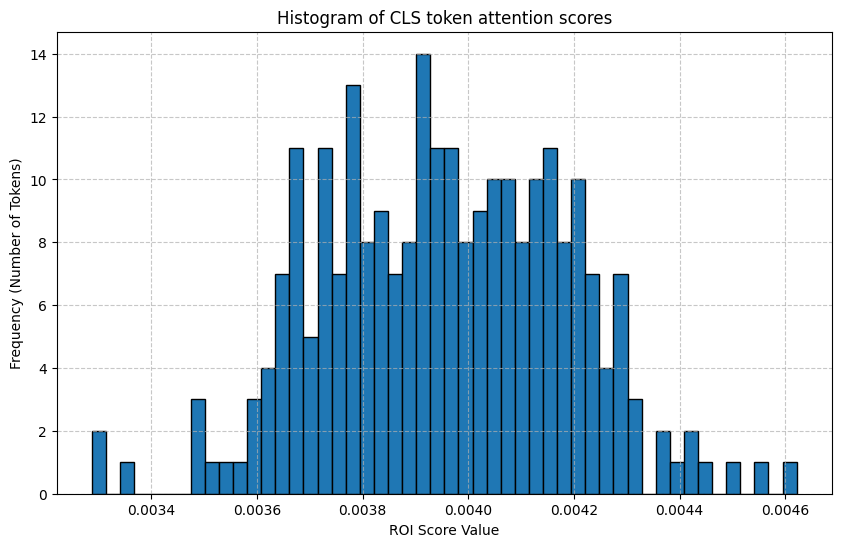

In [83]:

# 1. Histogram of Original Interpolated (but not yet softmaxed) Token ROI Scores
plt.figure(figsize=(10, 6))
plt.hist(cls_attn.numpy(), bins=50, edgecolor='black')
plt.title("Histogram of CLS token attention scores")
plt.xlabel("ROI Score Value")                                                                                                                   
plt.ylabel("Frequency (Number of Tokens)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()